<img src="../part_of_cover_bakker_post.png" width="800px">

The Python code provided below is from <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392

The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).

This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). 

<p>© 2022 Mark Bakker and Vincent Post</p>

# Analytic element modeling of steady two-dimensional flow 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## Uniform flow and wells

In [2]:
class Model:
    
    def __init__(self, T):
        self.T = T
        self.elements = [] # list of all elements
        
    def omega(self, x, y):
        omega = 0 + 0j
        for e in self.elements:
            omega += e.omega(x, y)
        return omega
    
    def potential(self, x, y):
        return self.omega(x, y).real
    
    def streamfunction(self, x, y):
        return self.omega(x, y).imag
        
    def head(self, x, y):
        return self.potential(x, y) / self.T
    
    def solve(self):
        esolve = [e for e in self.elements if e.nunknowns == 1]
        nunknowns = len(esolve)
        matrix = np.zeros((nunknowns, nunknowns))
        rhs = np.zeros(nunknowns)
        for irow in range(nunknowns):
            matrix[irow], rhs[irow] = esolve[irow].equation()
        solution = np.linalg.solve(matrix, rhs)
        for irow in range(nunknowns):
            esolve[irow].parameter = solution[irow]

In [3]:
class Element:
    
    def __init__(self, model, p):
        self.model = model
        self.parameter = p
        self.nunknowns = 0
        self.model.elements.append(self)
        
    def omega(self, x, y):
        return self.parameter * self.omegainf(x, y)
    
    def potential(self, x, y):
        return self.omega(x, y).real
    
    def potinf(self, x, y):
        return self.omegainf(x, y).real

In [4]:
class Well(Element):
    
    def __init__(self, model, xw=0, yw=0, Q=1, rw=0.3):
        Element.__init__(self, model, p=Q)
        self.zetaw = xw + 1j * yw
        self.rw = rw
            
    def omegainf(self, x, y):
        zminzw = x + 1j * y - self.zetaw
        zminzw = np.where(np.abs(zminzw) < self.rw, self.rw, zminzw)
        return 1 / (2 * np.pi) * np.log(zminzw)

In [5]:
class UniformFlow(Element):
    
    def __init__(self, model, gradient, angle):
        Element.__init__(self, model, p=model.T * gradient)
        self.udir = np.exp(-1j * np.deg2rad(angle))
        
    def omegainf(self, x, y):
        return -self.udir * (x + y * 1j)

In [6]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
Well(ml, xw=50, yw=0, Q=200) # extraction well, Q in m^3/d
Well(ml, xw=0, yw=0, Q=-100) # injection well, Q in m^3/d
UniformFlow(ml, gradient=0.002, angle=-45);

In [7]:
# solution
xg, yg = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-75, 75, 100))
pot = ml.potential(xg, yg)
psi = ml.streamfunction(xg, yg)

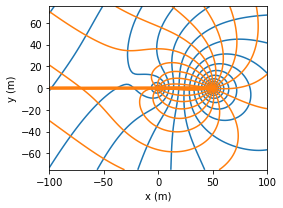

In [8]:
# basic flow net
plt.subplot(111, aspect=1)
plt.contour(xg, yg, pot, 20, colors='C0')
plt.contour(xg, yg, psi, 20, colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [9]:
class HeadEquation:

    def equation(self):
        row = []
        rhs = self.pc
        for e in self.model.elements:
            if e.nunknowns == 1:
                row.append(e.potinf(self.xc, self.yc))
            else:
                rhs -= e.potential(self.xc, self.yc)
        return row, rhs

In [10]:
class HeadWell(Well, HeadEquation):
    
    def __init__(self, model, xw, yw, rw, hw):
        Well.__init__(self, model, xw, yw, 0, rw)
        self.xc, self.yc = xw + rw, yw
        self.pc = self.model.T * hw
        self.nunknowns = 1

In [11]:
class Constant(Element, HeadEquation):
    
    def __init__(self, model, xc, yc, hc):
        Element.__init__(self, model, p=0)
        self.xc, self.yc = xc, yc
        self.pc = self.model.T * hc
        self.nunknowns = 1
        
    def omegainf(self, x, y):
        return np.ones_like(x, dtype='complex')

In [12]:
# parameters and model
ml = Model(T=100) # transmissivity in m^2/d
w1 = Well(ml, xw=0, yw=0, Q=100, rw=0.3) # Q in m^3/d
w2 = HeadWell(ml, xw=400, yw=300, rw=0.3, hw=20)
uf = UniformFlow(ml, gradient=0.002, angle=0)
rf = Constant(ml, xc=400, yc=0, hc=22)

In [13]:
# solution
ml.solve() # compute the unkown parameters
print(f'computed head at discharge-specified well: {ml.head(0, 0):.2f} m')
print(f'computed head at head-specified well: {ml.head(400.3, 300):.2f} m')
print(f'computed discharge of head-specified well: {w2.parameter:.2f} m^3/d')
print(f'computed head at reference point: {ml.head(400, 0):.2f} m')
# grid
xg, yg = np.meshgrid(np.linspace(-200, 600, 100), np.linspace(-100, 500, 100))
head = ml.head(xg, yg)
psi = ml.streamfunction(xg, yg)
print(f'min and max head on grid: {head.min():.2f}, {head.max():.2f}')
print(f'min and max psi on grid: {psi.min():.2f}, {psi.max():.2f}')

computed head at discharge-specified well: 21.81 m
computed head at head-specified well: 20.00 m
computed discharge of head-specified well: 185.10 m^3/d
computed head at reference point: 22.00 m
min and max head on grid: 20.57, 23.47
min and max psi on grid: -137.29, 66.91


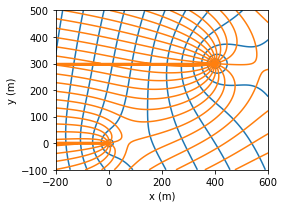

In [14]:
# basic flow net (right graph)
plt.subplot(111, aspect=1)
plt.contour(xg, yg, head, np.arange(20, 24, 0.2), colors='C0')
Q = w2.parameter # used to set stream function contour interval
plt.contour(xg, yg, psi, np.arange(-200, 100, Q / 20), colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

## Line-sinks for modeling rivers and streams

In [15]:
class LineSink(Element):
    
    def __init__(self, model, x0=0, y0=0, x1=1, y1=1, sigma=1):
        Element.__init__(self, model, sigma)
        self.z0 = x0 + y0 * 1j
        self.z1 = x1 + y1 * 1j
        self.L = np.abs(self.z1 - self.z0)
    
    def omegainf(self, x, y):
        zeta = x + y * 1j
        Z = (2 * zeta - (self.z0 + self.z1)) / (self.z1 - self.z0)
        Zp1 = np.where(np.abs(Z + 1) < 1e-12, 1e-12, Z + 1)
        Zm1 = np.where(np.abs(Z - 1) < 1e-12, 1e-12, Z - 1)
        return self.L / (4 * np.pi) * (Zp1 * np.log(Zp1) - Zm1 * np.log(Zm1))

In [16]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
ls1 = LineSink(ml, x0=-200, y0=-150, x1=200, y1=150, sigma=0.1) # sigma, m^2/d

In [17]:
# solution
xg, yg = np.meshgrid(np.linspace(-400, 400, 100), np.linspace(-300, 300, 100))
h = ml.head(xg, yg)
psi = ml.streamfunction(xg, yg)
xs, ys = np.linspace(-200, 200, 100), np.linspace(-150, 150, 100)
hs = ml.head(xs, ys) # head along line-sink

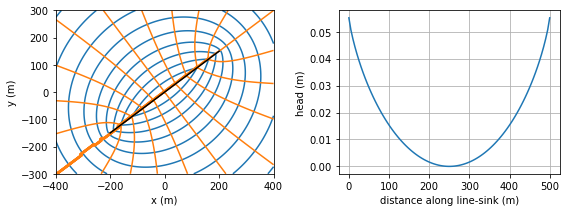

In [18]:
# basic plot
plt.subplot(121, aspect=1)
plt.contour(xg, yg, h, 10, colors='C0')
plt.contour(xg, yg, psi, 20, colors='C1')
plt.plot([-200, 200], [-150, 150], 'k')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122)
plt.plot(np.sqrt((xs + 200) **2 + (ys + 150) ** 2), hs)
plt.xlabel('distance along line-sink (m)')
plt.ylabel('head (m)')
plt.grid()

In [19]:
class HeadLineSink(LineSink, HeadEquation):
    
    def __init__(self, model, x0=0, y0=0, x1=1, y1=1, hc=1):
        LineSink.__init__(self, model, x0, y0, x1, y1, 0)
        self.xc = 0.5 * (x0 + x1)
        self.yc = 0.5 * (y0 + y1)
        self.pc = self.model.T * hc
        self.nunknowns = 1

In [20]:
# parameters and model
hriver = 10 # head in river, m
ml = Model(T=100) # transmissivity, m^2/d
rf = Constant(ml, xc=0, yc=1000, hc=hriver + 2)
w = HeadWell(ml, xw=0, yw=100, rw=0.3, hw=hriver - 2)
xls = np.linspace(-1600, 1600, 101) # x-locations of line-sinks, m
xls = np.hstack((np.arange(-1600, -400, 200), 
    np.arange(-400, 400, 50), np.arange(400, 1601, 200)))
yls = 50 * np.sin(np.pi * xls / 400) # y-locations of line-sinks, m
for i in range(len(xls) - 1):
    HeadLineSink(ml, x0=xls[i], y0=yls[i], 
                 x1=xls[i + 1], y1=yls[i + 1], hc=hriver)

In [21]:
# solution
ml.solve()
xg1, yg1 = np.meshgrid(np.linspace(-1800, 1800, 100), 
                       np.linspace(-1200, 1200, 100))
h1 = ml.head(xg1, yg1) # entire model
xg2, yg2 = np.meshgrid(np.linspace(-400, 400, 100), np.linspace(-100, 400, 100))
h2 = ml.head(xg2, yg2) # model around well

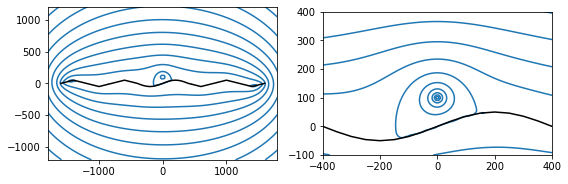

In [22]:
# basic contour plot
plt.subplot(121, aspect=1)
plt.contour(xg1, yg1, h1, 10, colors='C0')
plt.plot(xls, yls, 'k')
plt.subplot(122, aspect=1, xlim=(-400, 400))
plt.contour(xg2, yg2, h2, 10, colors='C0')
plt.plot(xls, yls, 'k');

## Area-sinks for modeling areal recharge

In [23]:
class AreaSink(Element):
    
    def __init__(self, model, xc=0, yc=0, N=0.001, R=100):
        Element.__init__(self, model, N)
        self.xc, self.yc = xc, yc
        self.R = R
            
    def omegainf(self, x, y):
        r = np.atleast_1d(np.sqrt((x - self.xc) ** 2 + (y - self.yc) ** 2))
        phi = np.zeros(r.shape)
        phi[r < self.R] = -0.25 * (r[r < self.R] ** 2 - self.R ** 2)
        phi[r >= self.R] = -self.R ** 2 / 2 * np.log(r[r >= self.R] / self.R)
        return phi + 0j

In [24]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
rf = Constant(ml, xc=0, yc=0, hc=20)
as1 = AreaSink(ml, xc=-500, yc=0, N=0.001, R=500) # recharge, m/d
as2 = AreaSink(ml, xc=500, yc=0, N=-0.001, R=500) # discharge, m/d

In [25]:
# solution
ml.solve()
xg, yg = np.meshgrid(np.linspace(-1500, 1500, 100), np.linspace(-800, 800, 101))        
h = ml.head(xg, yg)

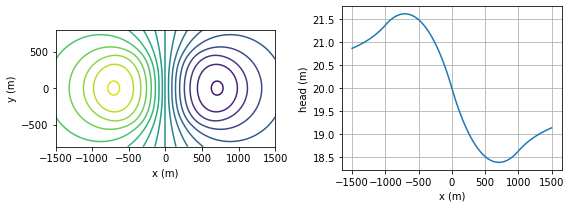

In [26]:
# basic plot
plt.subplot(121, aspect=1)
plt.contour(xg, yg, h, 20)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122)
plt.plot(xg[0], h[50])
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.grid();

In [27]:
# river segments, all in m
xls0 = [0, 100, 200, 400, 600, 800, 1000, 1100, 1200]
yls0 = [200, 200, 100, 100, 0, 0, 100, 300, 450]
hls0 = np.linspace(39, 40.4, 8)
xls1 = [0, 0, 200, 400, 600, 800, 1000, 1100, 1200]
yls1 = [200, 400, 600, 600, 700, 700, 750, 800, 850]
hls1 = np.linspace(39, 40.4, 8)

In [28]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
rf = Constant(ml, xc=0, yc=800, hc=39.5)
w0 = Well(ml, xw=500, yw=250, Q=100) # discharge, m^3/d
w1 = Well(ml, xw=800, yw=500, Q=100) # discharge, m^3/d
for i in range(len(hls0)):
    HeadLineSink(ml, xls0[i], yls0[i], xls0[i + 1], yls0[i + 1], hls0[i])
for i in range(len(hls1)):
    HeadLineSink(ml, xls1[i], yls1[i], xls1[i + 1], yls1[i + 1], hls1[i])
ar = AreaSink(ml, xc=600, yc=400, N=0.001, R=700) # recharge, m/d

In [29]:
# solution
ml.solve()
xg, yg = np.meshgrid(np.linspace(-100, 1300, 100), np.linspace(-100, 900, 100))
h = ml.head(xg, yg)

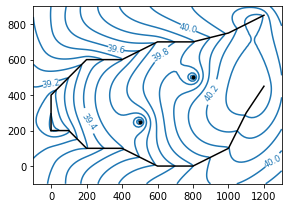

In [30]:
# basic contour plot (right side of figure)
plt.subplot(111, aspect=1)
cs = plt.contour(xg, yg, h, np.arange(38, 41, 0.2), colors='C0')
plt.clabel(cs, fmt='%1.1f', fontsize='smaller')
plt.contour(xg, yg, h, np.arange(38.1, 41, 0.2), colors='C0')
plt.plot(xls0, yls0, 'k')
plt.plot(xls1, yls1, 'k')
plt.plot([w0.zetaw.real, w1.zetaw.real], [w0.zetaw.imag, w1.zetaw.imag], 'k.');